# Sparse and Variational Gaussian Process Model Training and Performance Evaluation

In [1]:
from pathlib import Path
from shutil import copyfile
import pickle

Data manipulation

In [2]:
import numpy as np
import pandas as pd

Plotting / Visualisation

In [3]:
import matplotlib.pyplot as plt

In [4]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (15, 6)
plt.rcParams.update({'font.size': 16})

Gaussian Process Regression

In [5]:
import gpflow
import tensorflow as tf

In [6]:
from tensorflow.python.client import device_lib
from gpflow.ci_utils import ci_niter
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 9541726372704122629,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 3543400448
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 9177580535123742257
 physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1"]

In [7]:
from gpflow.utilities import print_summary

In [8]:
gpflow.config.set_default_summary_fmt("notebook")

In [9]:
from tqdm.contrib.itertools import product

Input scaler:

In [10]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.exceptions import NotFittedError

In [11]:
from helpers import ScalerHelper

## Load previously exported CARNOT 'experimental' data

In [12]:
dfs_train = []
dfs_test = []

Separate into training and testing data sets:

In [13]:
train_exps = ['Exp1', 'Exp3', 'Exp5', 'Exp6']
test_exps = ['Exp2', 'Exp4', 'Exp7']

In [14]:
for exp in train_exps:
    dfs_train.append(pd.read_csv(f"../Data/Good_CARNOT/{exp}_table.csv").rename(columns = {'Power': 'SimulatedHeat'}))
    
for exp in test_exps:
    dfs_test.append(pd.read_csv(f"../Data/Good_CARNOT/{exp}_table.csv").rename(columns = {'Power': 'SimulatedHeat'}))

Separate columns into exogenous inputs, controlled inputs and outputs:

In [15]:
#t_cols = ['time_h', 'time_m']
t_cols = []
w_cols = ['SolRad', 'OutsideTemp']
u_cols = ['SimulatedHeat']
y_cols = ['SimulatedTemp']

Impose the autoregressive lags for each input group:

In [16]:
t_lags = 0
w_lags = 1
u_lags = 2
y_lags = 3

In [17]:
dict_cols = {
    't': (t_lags, t_cols),
    'w': (w_lags, w_cols),
    'u': (u_lags, u_cols),
    'y': (y_lags, y_cols)
}

Create the scaler and set up input data scaling:

In [18]:
scaler = MinMaxScaler(feature_range = (-1, 1))

In [19]:
def get_scaled_df(df, dict_cols, scaler):
    
    t_list = dict_cols['t'][1]
    w_list = dict_cols['w'][1]
    u_list = dict_cols['u'][1]
    y_list = dict_cols['y'][1]
    
    df_local = df[t_list + w_list + u_list + y_list]
    df_scaled = df_local.to_numpy()
    
    try:
        df_scaled = scaler.transform(df_scaled)
    except NotFittedError:
        df_scaled = scaler.fit_transform(df_scaled)
        
    df_scaled = pd.DataFrame(df_scaled, index = df_local.index, columns = df_local.columns)
    
    return df_scaled

In [20]:
df_train = pd.concat(dfs_train)
df_train = df_train[t_cols + w_cols + u_cols + y_cols]
df_train.head()

,SolRad,OutsideTemp,SimulatedHeat,SimulatedTemp
0,57.936582,22.0,-31500,23.000000
1,54.914443,22.0,-31500,20.585367
2,73.944706,22.0,-31500,20.300922
3,76.206334,22.0,-31500,20.034647
4,65.120057,22.0,-31500,19.786064


Fit the scaler and scale the data:

In [21]:
df_train_sc = get_scaled_df(df_train, dict_cols, scaler)
#pickle.dump(scaler, open(Path("scaler.pkl"), 'wb'))

In [22]:
scaler_helper = ScalerHelper(scaler)

Scale the data for each experiment individually. Used for validation graphs and errors computation:

In [23]:
dfs_train_sc = []
dfs_test_sc = []
for df in dfs_train:
    df_sc = get_scaled_df(df, dict_cols, scaler)
    dfs_train_sc.append(df_sc)
    
for df in dfs_test:
    df_sc = get_scaled_df(df, dict_cols, scaler)
    dfs_test_sc.append(df_sc)

Set up the function which generated the GPR input matrix from the experimental data (including all autoregressive inputs, etc.):

In [24]:
def data_to_gpr(df, dict_cols):
    
    t_list = dict_cols['t'][1]
    w_list = dict_cols['w'][1]
    u_list = dict_cols['u'][1]
    y_list = dict_cols['y'][1]
    
    df_gpr = df[t_list + w_list + u_list + y_list].copy()
    
    for lags, names in dict_cols.values():
        for name in names:
            col_idx = df_gpr.columns.get_loc(name)
            for lag in range(1, lags + 1):
                df_gpr.insert(col_idx + lag, f"{name}_{lag}", df_gpr.loc[:, name].shift(lag))

    df_gpr.dropna(inplace = True)
    
    return df_gpr

Merge all the training dataframes:

In [25]:
dfs_gpr_train = []
for df_sc in dfs_train_sc:
    dfs_gpr_train.append(data_to_gpr(df_sc, dict_cols))
df_gpr_train = pd.concat(dfs_gpr_train)
df_gpr_train.head()

,SolRad,SolRad_1,OutsideTemp,OutsideTemp_1,SimulatedHeat,SimulatedHeat_1,SimulatedHeat_2,SimulatedTemp,SimulatedTemp_1,SimulatedTemp_2,SimulatedTemp_3
3,-0.855164,-0.859463,0.058824,0.058824,-1.0,-1.0,-1.0,-0.295224,-0.270561,-0.244215,-0.020567
4,-0.876235,-0.855164,0.058824,0.058824,-1.0,-1.0,-1.0,-0.318248,-0.295224,-0.270561,-0.244215
5,-0.911207,-0.876235,0.058824,0.058824,-1.0,-1.0,-1.0,-0.340062,-0.318248,-0.295224,-0.270561
6,-0.933425,-0.911207,0.058824,0.058824,1.0,-1.0,-1.0,-0.361066,-0.340062,-0.318248,-0.295224
7,-0.952322,-0.933425,0.058824,0.058824,-1.0,1.0,-1.0,0.051533,-0.361066,-0.340062,-0.318248


In [27]:
dfs_gpr_test = []
for df_sc in dfs_test_sc:
    dfs_gpr_test.append(data_to_gpr(df_sc, dict_cols))

In [28]:
df_input_train = df_gpr_train.drop(columns = dict_cols['w'][1] + dict_cols['u'][1] + dict_cols['y'][1])
df_output_train = df_gpr_train[dict_cols['y'][1]]

np_input_train = df_input_train.to_numpy()
np_output_train = df_output_train.to_numpy().reshape(-1, 1)

In [29]:
data_train = (np_input_train, np_output_train)
#pickle.dump(data_train, open(Path("data_train.pkl"), 'wb'))

In [30]:
df_input_train.head()

,SolRad_1,OutsideTemp_1,SimulatedHeat_1,SimulatedHeat_2,SimulatedTemp_1,SimulatedTemp_2,SimulatedTemp_3
3,-0.859463,0.058824,-1.0,-1.0,-0.270561,-0.244215,-0.020567
4,-0.855164,0.058824,-1.0,-1.0,-0.295224,-0.270561,-0.244215
5,-0.876235,0.058824,-1.0,-1.0,-0.318248,-0.295224,-0.270561
6,-0.911207,0.058824,-1.0,-1.0,-0.340062,-0.318248,-0.295224
7,-0.933425,0.058824,1.0,-1.0,-0.361066,-0.340062,-0.318248


In [31]:
## Define Kernel

In [32]:
nb_dims = np_input_train.shape[1]
rational_dims = np.arange(0, (dict_cols['t'][0] + 1) * len(dict_cols['t'][1]), 1)
nb_rational_dims = len(rational_dims)
squared_dims = np.arange(nb_rational_dims, nb_dims, 1)
nb_squared_dims = len(squared_dims)

In [33]:
print(f"rational: {nb_rational_dims}")
print(f"squared: {nb_squared_dims}")

rational: 0
squared: 7


In [34]:
squared_l = np.linspace(1, 1, nb_squared_dims)
rational_l = np.linspace(1, 1, nb_rational_dims)

In [35]:
variance = tf.math.reduce_variance(np_input_train)

In [36]:
k0 = gpflow.kernels.SquaredExponential(lengthscales = squared_l, active_dims = squared_dims, variance = variance)
k1 = gpflow.kernels.Constant(variance = variance)
k2 = gpflow.kernels.RationalQuadratic(lengthscales = rational_l, active_dims = rational_dims, variance = variance)
k3 = gpflow.kernels.Periodic(k2)
k4 = gpflow.kernels.RationalQuadratic(lengthscales = squared_l, active_dims = squared_dims, variance = variance)
k5 = gpflow.kernels.Matern32(lengthscales = squared_l, active_dims = squared_dims, variance = variance)

In [37]:
k = (k0 + k1) * k2
k = k0
print_summary(k)

name,class,transform,prior,trainable,shape,dtype,value
SquaredExponential.variance,Parameter,Softplus,,True,(),float64,0.46827645433285414
SquaredExponential.lengthscales,Parameter,Softplus,,True,"(7,)",float64,"[1., 1., 1...."


### Train SVGP model

In [38]:
N = data_train[0].shape[0]
M = 150 # Number of inducing locations
Z = data_train[0][:M, :].copy()

m = gpflow.models.SVGP(k, gpflow.likelihoods.Gaussian(), Z, num_data = N)

elbo = tf.function(m.elbo)

###
# Training
###

minibatch_size = 100
train_dataset = tf.data.Dataset.from_tensor_slices(data_train).repeat().shuffle(N)

# Turn off training for inducing point locations
gpflow.set_trainable(m.inducing_variable, False)

def run_adam(model, iterations):
    """
    Utility function running the Adam optimizer

    :param model: GPflow model
    :param interations: number of iterations
    """
    # Create an Adam Optimizer action
    logf = []
    train_iter = iter(train_dataset.batch(minibatch_size))
    training_loss = model.training_loss_closure(train_iter, compile=True)
    optimizer = tf.optimizers.Adam()

    @tf.function
    def optimization_step():
        optimizer.minimize(training_loss, model.trainable_variables)

    for step in range(iterations):
        optimization_step()
        if step % 10 == 0:
            elbo = -training_loss().numpy()
            logf.append(elbo)
    return logf


maxiter = ci_niter(10000)
logf = run_adam(m, maxiter)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


## Evaluate performance on training data

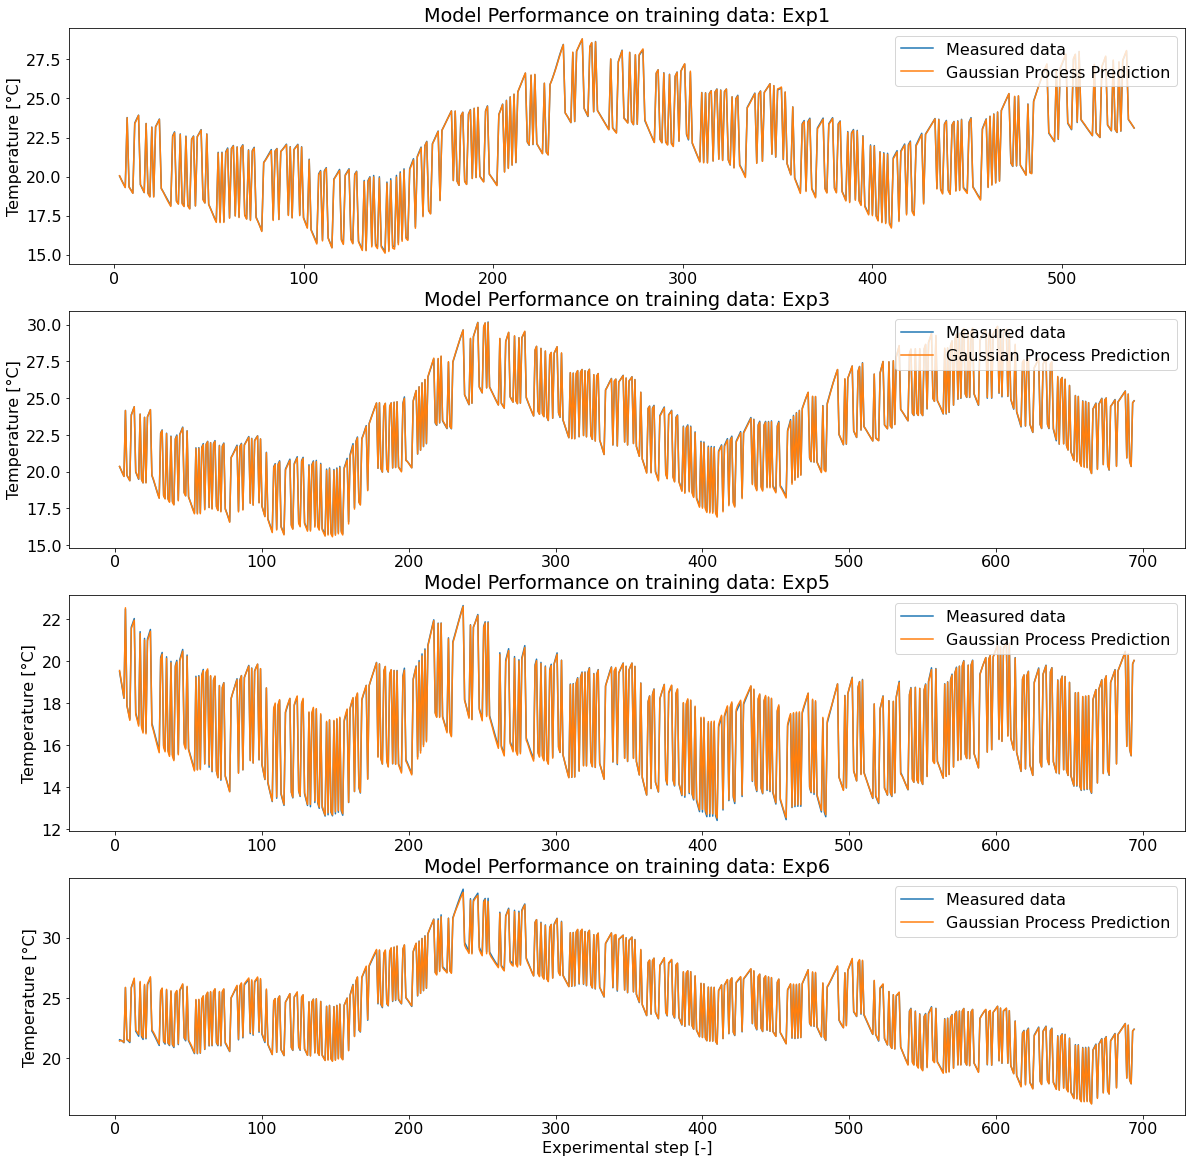

In [39]:
nb_plts = len(dfs_train)

fig, ax = plt.subplots(4, 1, figsize=(20, 20))

for idx, df_iter in enumerate(dfs_gpr_train):
    plt.subplot(4, 1, idx + 1)
    df_input_iter = df_iter.drop(columns = dict_cols['w'][1] + dict_cols['y'][1] + dict_cols['u'][1])
    df_output_iter = df_iter[dict_cols['y'][1]]
    np_input_iter = df_input_iter.to_numpy()
    np_output_iter = df_output_iter.to_numpy().reshape(-1, 1)
    
    mean, var = m.predict_f(np_input_iter)
    
    mean = scaler_helper.inverse_scale_output(mean).reshape((-1, 1))
    #var = scaler_helper.inverse_scale_output(var).reshape((-1, 1))
    scaled_measures = scaler_helper.inverse_scale_output(np_output_iter[:, :])
    
    plt.plot(df_iter.index, scaled_measures, label = 'Measured data')
    plt.plot(df_iter.index, mean, label = 'Gaussian Process Prediction')
    plt.fill_between(
        df_iter.index, 
        mean[:, 0] - 1.96 * np.sqrt(var[:, 0]),
        mean[:, 0] + 1.96 * np.sqrt(var[:, 0]),
        alpha = 0.2
    )
    plt.title(f"Model Performance on training data: {train_exps[idx]}")
    plt.ylabel("Temperature [°C]")
    plt.legend(loc = 'upper right')
    
ax[-1].set_xlabel("Experimental step [-]")
plt.savefig(f"../Thesis/Plots/SVGP_{w_lags}{u_lags}{y_lags}_training_performance.pdf", bbox_inches='tight')

## Evaluate performance on test data

In [40]:
def SMSE(measured, predicted):
    N = measured.size
    measured_var = np.var(measured)
    SMSE = np.power(measured - predicted, 2).sum()/(N*measured_var)
    return SMSE

In [41]:
def RMSE(measured, predicted):
    N = measured.size
    RMSE = np.sqrt(np.power(measured - predicted, 2).sum()/N)
    return RMSE

In [42]:
def LPD(measured, predicted_mean, predicted_var):
    N = measured.size
    sum_part = np.log(predicted_var) + np.power(measured - predicted_mean, 2)/predicted_var
    LPD = 1/2*np.log(2*np.pi) + 1/(2*N)*sum_part.sum()
    return LPD

In [43]:
def MSLL(measured, predicted_mean, predicted_var):
    measured_var = np.var(measured)
    measured_mean = np.mean(measured)
    return LPD(measured, predicted_mean, predicted_var) - LPD(measured, measured_mean, measured_var)

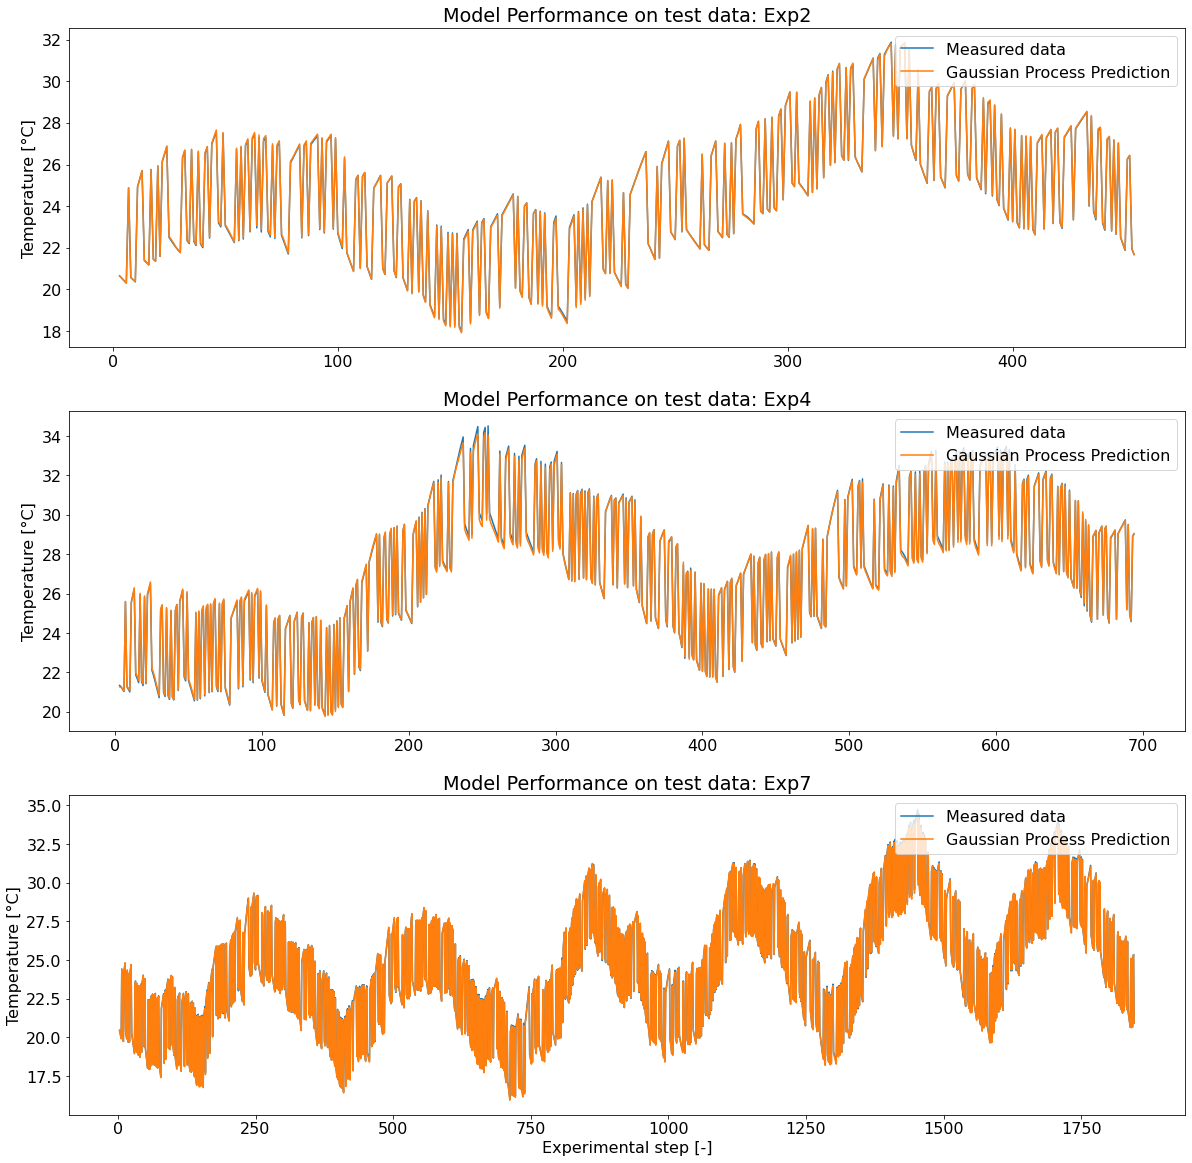

In [44]:
nb_plts = len(dfs_test)

test_smse = 0
test_rmse = 0
test_lpd = 0
test_msll = 0

fig, ax = plt.subplots(3, 1, figsize=(20, 20))

for idx, df_iter in enumerate(dfs_gpr_test):
    plt.subplot(nb_plts, 1, idx + 1)
    df_input_iter = df_iter.drop(columns = dict_cols['w'][1] + dict_cols['y'][1] + dict_cols['u'][1])
    df_output_iter = df_iter[dict_cols['y'][1]]
    np_input_iter = df_input_iter.to_numpy()
    np_output_iter = df_output_iter.to_numpy().reshape(-1, 1)
    
    mean, var = m.predict_f(np_input_iter)
    mean = mean.numpy()
    var = var.numpy()
    
    mean = scaler_helper.inverse_scale_output(mean).reshape((-1, 1))
    #var = scaler_helper.inverse_scale_output(var).reshape((-1, 1))
    scaled_measures = scaler_helper.inverse_scale_output(np_output_iter[:, :])
    
    test_smse += SMSE(np_output_iter, mean)
    test_rmse += RMSE(np_output_iter, mean)
    test_lpd += LPD(np_output_iter, mean, var)
    test_msll += MSLL(np_output_iter, mean, var)

    
    plt.plot(df_iter.index, scaled_measures, label = 'Measured data')
    plt.plot(df_iter.index, mean[:, :], label = 'Gaussian Process Prediction')
    plt.fill_between(
        df_iter.index, 
        mean[:, 0] - 1.96 * np.sqrt(var[:, 0]),
        mean[:, 0] + 1.96 * np.sqrt(var[:, 0]),
        alpha = 0.2
    )
    plt.title(f"Model Performance on test data: {test_exps[idx]}")
    plt.ylabel("Temperature [°C]")
    plt.legend(loc = 'upper right')
    
ax[-1].set_xlabel("Experimental step [-]")
plt.savefig(f"../Thesis/Plots/SVGP_{w_lags}{u_lags}{y_lags}_test_performance.pdf", bbox_inches='tight')

In [45]:
print(f"--- Lags ---")
print(f"w_lags: {w_lags}, u_lags: {u_lags}, y_lags: {y_lags}")
print("--- Test errors ---")
print(f"RMSE: {test_rmse}, SMSE: {test_smse}, MSLL: {test_msll}, LPD: {test_lpd}")

--- Lags ---
w_lags: 1, u_lags: 2, y_lags: 3
--- Test errors ---
RMSE: 76.24100333005036, SMSE: 17786.390395104558, MSLL: 61630028.21520755, LPD: 61630029.16856581


## Generate a table of errors and lengthscales

In [46]:
#t_cols = ['time_h', 'time_m']
t_cols = []
w_cols = ['SolRad', 'OutsideTemp']
u_cols = ['SimulatedHeat']
y_cols = ['SimulatedTemp']

In [47]:
# Max lags, used to generate columns index
t_lags = 0
w_lags = 5
u_lags = 5
y_lags = 5

Iterate over all combination of lags and compute for each the RMSE, SMSE, LPD and MSLL errors:

In [54]:
dict_cols = {
    't': (t_lags, t_cols),
    'w': (w_lags, w_cols),
    'u': (u_lags, u_cols),
    'y': (y_lags, y_cols)
}

In [55]:
lags_cols = ['w_lags', 'u_lags', 'y_lags']
err_cols = ['rmse', 'smse', 'msll', 'lpd'] + ['variance']
lscales_cols = data_to_gpr(df_sc, dict_cols).drop(columns = dict_cols['w'][1] + dict_cols['y'][1] + dict_cols['u'][1]).columns.to_list()

In [56]:
df_perf_cols = lags_cols + err_cols + lscales_cols

In [57]:
np_perf = np.empty((0, len(df_perf_cols)))

In [58]:
w_range = np.arange(1,6)
u_range = np.arange(1,6)
y_range = np.arange(1,6)

In [ ]:
np_perf = np.empty((0, len(df_perf_cols)))
for w_iter, u_iter, y_iter in product(w_range, u_range, y_range):

    # Define dict_cols
    dict_cols = {
        't': (t_lags, t_cols),
        'w': (w_iter, w_cols),
        'u': (u_iter, u_cols),
        'y': (y_iter, y_cols)
    }

    # Training data
    dfs_gpr_train = []
    for df_sc in dfs_train_sc:
        dfs_gpr_train.append(data_to_gpr(df_sc, dict_cols))
    df_gpr_train = pd.concat(dfs_gpr_train)

    dfs_gpr_test = []
    for df_sc in dfs_test_sc:
        dfs_gpr_test.append(data_to_gpr(df_sc, dict_cols))

    df_input_train = df_gpr_train.drop(columns = dict_cols['w'][1] + dict_cols['u'][1] + dict_cols['y'][1])
    df_output_train = df_gpr_train[dict_cols['y'][1]]

    np_input_train = df_input_train.to_numpy()
    np_output_train = df_output_train.to_numpy().reshape(-1, 1)

    data_train = (np_input_train, np_output_train)


    # Kernel
    nb_dims = np_input_train.shape[1]
    rational_dims = np.arange(0, (dict_cols['t'][0] + 1) * len(dict_cols['t'][1]), 1)
    nb_rational_dims = len(rational_dims)
    squared_dims = np.arange(nb_rational_dims, nb_dims, 1)
    nb_squared_dims = len(squared_dims)

    squared_l = np.linspace(1, 1, nb_squared_dims)
    rational_l = np.linspace(1, 1, nb_rational_dims)

    nb_tries = 0
    train_success = False
    while True:
        try:
            if nb_tries > 2:
                break
            k0 = gpflow.kernels.SquaredExponential(lengthscales = squared_l, active_dims = squared_dims, variance = variance)
            k = k0     

            N = data_train[0].shape[0]
            M = 150 # Number of inducing locations
            Z = data_train[0][:M, :].copy()

            m = gpflow.models.SVGP(k, gpflow.likelihoods.Gaussian(), Z, num_data = N)

            elbo = tf.function(m.elbo)

            ###
            # Training
            ###

            minibatch_size = 100
            train_dataset = tf.data.Dataset.from_tensor_slices(data_train).repeat().shuffle(N)

            # Turn off training for inducing point locations
            gpflow.set_trainable(m.inducing_variable, False)

            def run_adam(model, iterations):
                """
                Utility function running the Adam optimizer

                :param model: GPflow model
                :param interations: number of iterations
                """
                # Create an Adam Optimizer action
                logf = []
                train_iter = iter(train_dataset.batch(minibatch_size))
                training_loss = model.training_loss_closure(train_iter, compile=True)
                optimizer = tf.optimizers.Adam()

                @tf.function
                def optimization_step():
                    optimizer.minimize(training_loss, model.trainable_variables)

                for step in range(iterations):
                    optimization_step()
                    if step % 10 == 0:
                        elbo = -training_loss().numpy()
                        logf.append(elbo)
                return logf


            maxiter = ci_niter(10000)
            logf = run_adam(m, maxiter)

            train_success = True
            break
        except:
            nb_tries += 1

    if not train_success:
        continue

    nb_plts = len(dfs_test)

    test_smse = 0
    test_rmse = 0
    test_lpd = 0
    test_msll = 0

    for idx, df_iter in enumerate(dfs_gpr_test):
        df_input_iter = df_iter.drop(columns = dict_cols['w'][1] + dict_cols['y'][1] + dict_cols['u'][1])
        df_output_iter = df_iter[dict_cols['y'][1]]
        np_input_iter = df_input_iter.to_numpy()
        np_output_iter = df_output_iter.to_numpy().reshape(-1, 1)

        mean, var = m.predict_f(np_input_iter)

        test_smse += SMSE(np_output_iter, mean.numpy())
        test_rmse += RMSE(np_output_iter, mean.numpy())
        test_lpd += LPD(np_output_iter, mean.numpy(), var.numpy())
        test_msll += MSLL(np_output_iter, mean.numpy(), var.numpy())

    # Compute the current row in df_perf

    iter_lagcols = df_input_train.columns.tolist()

    np_perf_iter = np.nan * np.ones((1, len(df_perf_cols)))
    np_perf_iter[0,0] = w_iter
    np_perf_iter[0,1] = u_iter
    np_perf_iter[0,2] = y_iter
    np_perf_iter[0,3] = test_rmse
    np_perf_iter[0,4] = test_smse
    np_perf_iter[0,5] = test_msll
    np_perf_iter[0,6] = test_lpd
    np_perf_iter[0,7] = gpflow.utilities.parameter_dict(m)['.kernel.variance'].numpy()

    for iter_lag in iter_lagcols:
        iter_lag_idx = df_input_train.columns.to_list().index(iter_lag)
        perf_lag_idx = df_perf_cols.index(iter_lag)
        np_perf_iter[0,perf_lag_idx] = gpflow.utilities.parameter_dict(m)['.kernel.lengthscales'].numpy()[iter_lag_idx]


    np_perf = np.vstack([np_perf, np_perf_iter])

    # Save the output for this iteration
    df_perf_iter = pd.DataFrame(np_perf, columns = df_perf_cols).to_csv(f"df_perf_SVGP_{w_iter}w_{u_iter}u_{y_iter}y.csv")

In [ ]:
gpflow.utilities.parameter_dict(m)['.kernel.lengthscales'].numpy()

## Multistep prediction

Select the dataset which will be used for multistep prediction:

In [47]:
test_dataset_idx = 1
df_input = dfs_gpr_test[test_dataset_idx].drop(columns = dict_cols['w'][1] + dict_cols['u'][1] + dict_cols['y'][1])
df_output = dfs_gpr_test[test_dataset_idx][dict_cols['y'][1]]

Select the starting index in the test dataset and the number of consecutive points to simulate:

In [48]:
start_idx = 25
nb_predictions = 25
N_pred = 20

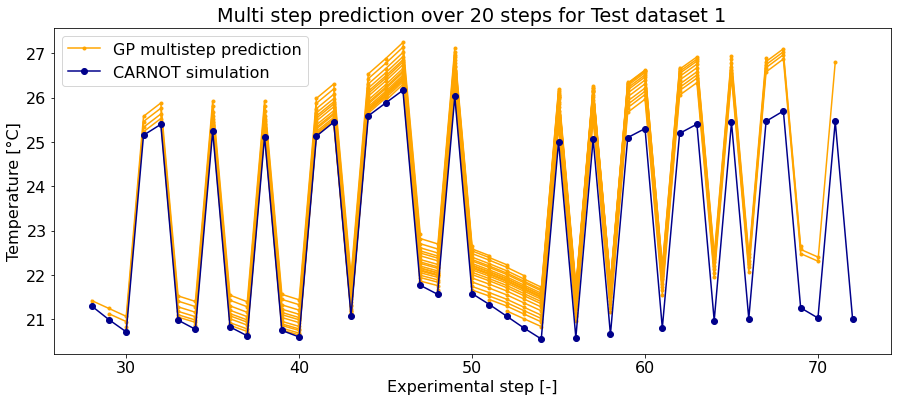

In [55]:
fig, ax = plt.subplots()

y_name = dict_cols['y'][1][0]
for idx in range(start_idx, start_idx + nb_predictions):
    df_iter = df_input.iloc[idx:(idx + N_pred)].copy()
    for idxx in range(N_pred - 1):
        idx_old = df_iter.index[idxx]
        idx_new = df_iter.index[idxx+1]
        mean, var = m.predict_f(df_iter.loc[idx_old, :].to_numpy().reshape(1, -1))
        df_iter.loc[idx_new, f'{y_name}_1'] = mean.numpy().flatten()
        for lag in range(2, dict_cols['y'][0] + 1):
            df_iter.loc[idx_new, f"{y_name}_{lag}"] = df_iter.loc[idx_old, f"{y_name}_{lag-1}"]

    mean_iter, var_iter = m.predict_f(df_iter.to_numpy())
    mean_iter = scaler_helper.inverse_scale_output(mean_iter)
    plt.plot(df_iter.index, mean_iter, '.-', label = 'GP multistep prediction', color = 'orange')
scaled_index = df_output.iloc[start_idx:start_idx + nb_predictions + N_pred].index
scaled_measurement = scaler_helper.inverse_scale_output(df_output.iloc[start_idx:start_idx + nb_predictions + N_pred])
plt.plot(scaled_index, scaled_measurement, 'o-', label = 'CARNOT simulation', color = 'darkblue')


handles, labels = ax.get_legend_handles_labels()
idx = np.sort(np.unique(np.array(labels), return_index=True)[1])
plt.legend(np.array(handles)[idx], np.array(labels)[idx], loc = 'upper left')

plt.ylabel("Temperature [°C]")
    
ax.set_xlabel("Experimental step [-]")

plt.title(f"Multi step prediction over {N_pred} steps for Test dataset {test_dataset_idx}")
plt.savefig(f"../Thesis/Plots/SVGP_{w_lags}{u_lags}{y_lags}_test_prediction_{N_pred}_steps.pdf")